In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from data_utils import load_dataset

In [2]:
np.random.seed(100)

In [3]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

# use first 1000 training points
x_train, y_train = x_train[:1000], y_train[:1000]

# define number of iterations to run for full-batch
num_iterations = 100

# define number of epochs for stochastic gradient descent
num_epochs = 5

# define learning rates to test
learning_rates = [0.0001, 0.001, 0.002, 0.005, 0.01]

# define momentum hyperparameters to test
betas = [0.01,0.05, 0.1, 0.5, 0.7, 0.9]

In [4]:
# some helper functions
def compute_RMSE(y1, y2):
    return np.sqrt(np.mean(np.square(y1-y2)))

In [5]:
def loss(y, y_hat, N):
    return (1/N) * np.sum(np.square(y - y_hat))

def grad_loss(y_i, y_hat_i, x_i):
    # y_i is scalar
    # y_hat_i is scalar
    # x_i is (33,1) column vector, with x_i_0 = 1 is dummy feature
    
    return 2 * (y_i - y_hat_i) * (-x_i)

def gradient_descent_full_batch(x_train, y_train, x_test, y_test, learning_rates, optimal_RMSE, optimal_loss):
    print("\nTraining full-batch gradient descent...")
    
    X = np.hstack((np.ones((x_train.shape[0], 1)), x_train)) # add dummy feature x_0 = 1
    
    N = X.shape[0] # num training points
    D = X.shape[1] # dimension of each training input (including dummy feature)
    
    X_test = np.hstack((np.ones((x_test.shape[0],1)), x_test)) # X matrix for test data
    
    # test each learning rate and find the number of iterations and computation time to converge
    rate_dict = {}    
    for rate in learning_rates:
        
        print("\n")
        print("Rate: {}".format(rate))
        
        RMSEs = []
        losses = []
        rate_dict[rate] = []
        
        print("Beginning training...")
        tic = time.time()
        
        # initialize weights to 0
        w_k = np.zeros((D,1))
        
        y_hat = X.dot(w_k)
        train_RMSE = compute_RMSE(y_train, y_hat)
        RMSEs.append(train_RMSE)
        L = loss(y_train, y_hat, N)
        losses.append(L)
        
        k = 0
        
        while losses[k] > 1.05*optimal_loss: # have convergence to within 5% of optimal_loss

            # print("Current loss: {}".format(losses[k]))
            k += 1
            # compute gradient
            gradient_L = np.zeros((D,1))
            for i in range(N):
                gradient_L += grad_loss(y_train[i], y_hat[i], X[i].reshape(D,1))
            gradient_L = gradient_L / N
            
            # update weights
            w_k = w_k - rate*gradient_L
                                            
            y_hat = X.dot(w_k)
            train_RMSE = compute_RMSE(y_train, y_hat)
            RMSEs.append(train_RMSE)
            L = loss(y_train, y_hat, N)
            losses.append(L)
        
        toc = time.time()
        
        print("Took {}s".format(round(toc-tic,6)))
        print("Took {} iterations".format(k))
        
        rate_dict[rate].append(RMSEs)
        rate_dict[rate].append(losses)
        rate_dict[rate].append(toc-tic)
        rate_dict[rate].append(k)
    
    # now test all learning rates with a fixed number of iterations
    rate_dict_fixed_iter = {}
    for rate in learning_rates:
        
        RMSEs = []
        losses = []
        rate_dict_fixed_iter[rate] = []
        
        # initialize weights to 0
        w_k = np.zeros((D,1))
        
        y_hat = X.dot(w_k)
        train_RMSE = compute_RMSE(y_train, y_hat)
        RMSEs.append(train_RMSE)
        L = loss(y_train, y_hat, N)
        losses.append(L)
        
        for i in range(num_iterations):

            # compute gradient
            gradient_L = np.zeros((D,1))
            for i in range(N):
                gradient_L += grad_loss(y_train[i], y_hat[i], X[i].reshape(D,1))
            gradient_L = gradient_L / N
            
            # update weights
            w_k = w_k - rate*gradient_L
                                            
            y_hat = X.dot(w_k)
            train_RMSE = compute_RMSE(y_train, y_hat)
            RMSEs.append(train_RMSE)
            L = loss(y_train, y_hat, N)
            losses.append(L)
        
        rate_dict_fixed_iter[rate].append(RMSEs)
        rate_dict_fixed_iter[rate].append(losses)
        rate_dict_fixed_iter[rate].append(w_k) # final weights
    
    return rate_dict, rate_dict_fixed_iter

def stochastic_gradient_descent(x_train, y_train, x_test, y_test, learning_rates, optimal_RMSE, batch_size):
    print("\nTraining stochastic gradient descent with batch size {}...".format(batch_size))
    
    X = np.hstack((np.ones((x_train.shape[0], 1)), x_train)) # add dummy feature x_0 = 1
    
    N = X.shape[0] # num training points
    D = X.shape[1] # dimension of each training input (including dummy feature)
    
    X_test = np.hstack((np.ones((x_test.shape[0],1)), x_test)) # X matrix for test data
    
    rate_dict = {} 
    
    for rate in learning_rates:
        
        print("\n")
        print("Rate: {}".format(rate))
        
        RMSEs = []
        losses = []
        
        epoch_RMSEs = []
        epoch_losses = []
        
        rate_dict[rate] = []
        
        print("Beginning training...")
        tic = time.time()
        
        # initialize weights to 0
        w_k = np.zeros((D,1))
        
        y_hat = X.dot(w_k)
        train_RMSE = compute_RMSE(y_train, y_hat)
        RMSEs.append(train_RMSE)
        L = loss(y_train, y_hat, N)
        losses.append(L)
        
        epoch_RMSEs.append(train_RMSE)
        epoch_losses.append(L)
        
        # shuffle training indices
        idxs = np.arange(N)
        np.random.shuffle(idxs)
        
        for epoch in range(num_epochs):
            
            if batch_size == 1:
                for i in range(len(idxs)):
                    w_k -= rate * grad_loss(y_train[idxs[i]], y_hat[idxs][i], X[idxs[i]].reshape(D,1))
                    
                    y_hat = X.dot(w_k)
                    train_RMSE = compute_RMSE(y_train, y_hat)
                    RMSEs.append(train_RMSE)
                    L = loss(y_train, y_hat, N)
                    losses.append(L)
            
            elif batch_size == 10:
                for i in range(len(idxs)//10):
                    gradient_L = np.zeros((D,1))
                    for j in range(10):
                        gradient_L += grad_loss(y_train[idxs[10*i+j]], y_hat[idxs[10*i+j]], X[idxs[10*i+j]].reshape(D,1))
                    w_k -= rate * gradient_L
                    
                    y_hat = X.dot(w_k)
                    train_RMSE = compute_RMSE(y_train, y_hat)
                    RMSEs.append(train_RMSE)
                    L = loss(y_train, y_hat, N)
                    losses.append(L)
            
            epoch_RMSEs.append(train_RMSE)
            epoch_losses.append(L)
        
        toc = time.time()
        print("Took {}s".format(round(toc-tic,6)))            
                    
        rate_dict[rate].append(RMSEs) # 0
        rate_dict[rate].append(losses) # 1
        rate_dict[rate].append(epoch_RMSEs) # 2
        rate_dict[rate].append(epoch_losses) # 3
        
        rate_dict[rate].append(toc-tic) # 4
        
        rate_dict[rate].append(w_k) # 5 final weights
    
    return rate_dict

def stochastic_gradient_descent_momentum(x_train, y_train, x_test, y_test, learning_rates, betas, optimal_RMSE):
    print("\nTraining stochastic gradient descent with momentum, with batch size 1")
    
    X = np.hstack((np.ones((x_train.shape[0], 1)), x_train)) # add dummy feature x_0 = 1
    
    N = X.shape[0] # num training points
    D = X.shape[1] # dimension of each training input (including dummy feature)
    
    X_test = np.hstack((np.ones((x_test.shape[0],1)), x_test)) # X matrix for test data
    
    rate_dict = {}  
    
    for rate in learning_rates:
        rate_dict[rate] = {} # rate_dict[rate][beta] = [[RMSEs], [losses]]
        for beta in betas:
            
            print("\n")
            print("Rate: {}, beta: {}".format(rate, beta))
  
            beta_list = []
            
            RMSEs = []
            losses = []
            
            epoch_RMSEs = []
            epoch_losses = []
          
            print("Beginning training...")
            tic = time.time()
            
            # initialize weights to 0
            w_k = np.zeros((D,1))

            y_hat = X.dot(w_k)
            train_RMSE = compute_RMSE(y_train, y_hat)
            RMSEs.append(train_RMSE)
            L = loss(y_train, y_hat, N)
            losses.append(L)
  
            epoch_RMSEs.append(train_RMSE)
            epoch_losses.append(L)
        
            # shuffle training indices
            idxs = np.arange(N)
            np.random.shuffle(idxs)
            
            for epoch in range(num_epochs):
                for i in range(len(idxs)):

                    if i == 0 and epoch == 0:
                        gradient_L = grad_loss(y_train[idxs[i]], y_hat[idxs][i], X[idxs[i]].reshape(D,1))
                    else:
                        gradient_L = beta*gradient_L + (1-beta)*grad_loss(y_train[idxs[i]], y_hat[idxs][i], X[idxs[i]].reshape(D,1))


                    w_k -= rate * gradient_L

                    y_hat = X.dot(w_k)
                    train_RMSE = compute_RMSE(y_train, y_hat)
                    RMSEs.append(train_RMSE)
                    L = loss(y_train, y_hat, N)
                    losses.append(L)
                
                epoch_RMSEs.append(train_RMSE)
                epoch_losses.append(L)

            toc = time.time()
            print("Took {}s".format(round(toc-tic,6)))
          
            beta_list.append(RMSEs)
            beta_list.append(losses)
            beta_list.append(epoch_RMSEs)
            beta_list.append(epoch_losses)
          
            beta_list.append(toc-tic)
            
            beta_list.append(w_k)
            
            rate_dict[rate][beta] = beta_list
            
    return rate_dict
            
    pass

In [6]:
# exact linear regression solution from Assignment 1
def lin_regress_SVD(x_train, y_train, x_test, y_test):
    
    # x_train is an (N,D) array
    # N training points, D features
    # y_train is an (N,1) array for regression and (N,y) for classification
    # assume classification datasets converted to number classes
    
    # add dummy feature (for bias/offset term)
    # change x_train to (N,D+1) array; x_test to (n,D+1) array
    # n is number of test points
    
    temp = np.ones((x_train.shape[0], 1))
    x_train = np.hstack((temp, x_train))
    temp = np.ones((x_test.shape[0], 1))
    x_test = np.hstack((temp, x_test))
    
    # compute SVD
    U, sigma, V_t = np.linalg.svd(x_train, full_matrices=False, compute_uv=True, hermitian=False)
    # U is (N,D+1); sigma is (D+1,) array of the singular values; because full_matrics=False
    # V_t is (D+1,D+1)
    
    # compute weights with numpy multidot
    # using formula derived in lecture
    w = np.linalg.multi_dot([V_t.T,np.linalg.inv(np.diag(sigma)),U.T,y_train])
    
    # compute prediction
    y_predict = np.dot(x_train,w)
    
    # compute RMSE
    RMSE = compute_RMSE(y_predict, y_train)
    
    # compute loss
    y_hat = x_train.dot(w)
    N = x_train.shape[0]
    L = loss(y_train, y_hat, N)
    
    return RMSE, L, w

In [7]:
def predict(X, w):
    temp = np.ones((X.shape[0], 1))
    X = np.hstack((temp, X)) # add dummy feature x_0 = 1
    
    return X.dot(w)

In [8]:
optimal_RMSE, optimal_loss, optimal_weights = lin_regress_SVD(x_train, y_train, x_test, y_test)
print(optimal_RMSE)
print(optimal_loss)

0.8494765871632222
0.7216104721384754


In [9]:
GD_full_batch, GD_full_batch_fixed_iter = gradient_descent_full_batch(x_train, y_train, x_test, y_test, learning_rates, optimal_RMSE, optimal_loss)


Training full-batch gradient descent...


Rate: 0.0001
Beginning training...
Took 43.146652s
Took 4964 iterations


Rate: 0.001
Beginning training...
Took 4.484926s
Took 496 iterations


Rate: 0.002
Beginning training...
Took 2.132327s
Took 248 iterations


Rate: 0.005
Beginning training...
Took 0.831003s
Took 99 iterations


Rate: 0.01
Beginning training...
Took 0.411686s
Took 50 iterations


In [10]:
SGD_batch_1 = stochastic_gradient_descent(x_train, y_train, x_test, y_test, learning_rates, optimal_RMSE, batch_size=1)


Training stochastic gradient descent with batch size 1...


Rate: 0.0001
Beginning training...
Took 0.437271s


Rate: 0.001
Beginning training...
Took 0.377826s


Rate: 0.002
Beginning training...
Took 0.374298s


Rate: 0.005
Beginning training...
Took 0.383923s


Rate: 0.01
Beginning training...
Took 0.354335s


In [11]:
SGD_batch_10 = stochastic_gradient_descent(x_train, y_train, x_test, y_test, learning_rates, optimal_RMSE, batch_size=10)


Training stochastic gradient descent with batch size 10...


Rate: 0.0001
Beginning training...
Took 0.12301s


Rate: 0.001
Beginning training...
Took 0.083032s


Rate: 0.002
Beginning training...
Took 0.082591s


Rate: 0.005
Beginning training...
Took 0.07834s


Rate: 0.01
Beginning training...
Took 0.080077s


In [12]:
SGD_momentum = stochastic_gradient_descent_momentum(x_train, y_train, x_test, y_test, learning_rates, betas, optimal_RMSE)


Training stochastic gradient descent with momentum, with batch size 1


Rate: 0.0001, beta: 0.01
Beginning training...
Took 0.460246s


Rate: 0.0001, beta: 0.05
Beginning training...
Took 0.430507s


Rate: 0.0001, beta: 0.1
Beginning training...
Took 0.437744s


Rate: 0.0001, beta: 0.5
Beginning training...
Took 0.376701s


Rate: 0.0001, beta: 0.7
Beginning training...
Took 0.415986s


Rate: 0.0001, beta: 0.9
Beginning training...
Took 0.343911s


Rate: 0.001, beta: 0.01
Beginning training...
Took 0.366608s


Rate: 0.001, beta: 0.05
Beginning training...
Took 0.396762s


Rate: 0.001, beta: 0.1
Beginning training...
Took 0.359224s


Rate: 0.001, beta: 0.5
Beginning training...
Took 0.355111s


Rate: 0.001, beta: 0.7
Beginning training...
Took 0.363493s


Rate: 0.001, beta: 0.9
Beginning training...
Took 0.362115s


Rate: 0.002, beta: 0.01
Beginning training...
Took 0.3928s


Rate: 0.002, beta: 0.05
Beginning training...
Took 0.373519s


Rate: 0.002, beta: 0.1
Beginning training...
Took

Number of iterations and computation time to reach convergence of 5% within optimal loss:
Learning rate: 0.0001
	Full-batch took: 43.146652s and 4964 iterations
Learning rate: 0.001
	Full-batch took: 4.484926s and 496 iterations
Learning rate: 0.002
	Full-batch took: 2.132327s and 248 iterations
Learning rate: 0.005
	Full-batch took: 0.831003s and 99 iterations
Learning rate: 0.01
	Full-batch took: 0.411686s and 50 iterations


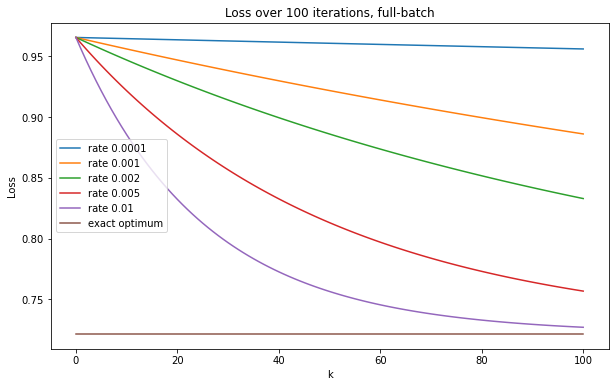

Test RMSE results using the weights found from 100 iterations:
Learning rate: 0.0001
	Test RMSE: 0.962061
Learning rate: 0.001
	Test RMSE: 0.930615
Learning rate: 0.002
	Test RMSE: 0.906751
Learning rate: 0.005
	Test RMSE: 0.874683
Learning rate: 0.01
	Test RMSE: 0.866815
Best rate: 0.01, with min test RMSE: 0.866815


In [13]:
# print results for full-batch gradient descent

# print convergence test results
print("Number of iterations and computation time to reach convergence of 5% within optimal loss:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    print("\tFull-batch took: {}s and {} iterations".format(round(GD_full_batch[rate][2],6), GD_full_batch[rate][3]))

# print fixed iterations results
ks_GD_full_batch = np.arange(num_iterations+1)
plt.figure(figsize=(10,6))
for rate in learning_rates:
    plt.plot(ks_GD_full_batch, GD_full_batch_fixed_iter[rate][1], label="rate {}".format(rate))
plt.plot(ks_GD_full_batch, np.ones(len(ks_GD_full_batch))*optimal_loss, label="exact optimum") # loss
plt.xlabel("k")
plt.ylabel("Loss")
plt.title("Loss over {} iterations, full-batch".format(num_iterations))
plt.legend(loc='best')
plt.show()

# find test RMSE using weights from the fixed iteration tests
best_rate = None
best_test_RMSE = float('inf')
print("Test RMSE results using the weights found from 100 iterations:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    y_star = predict(x_test, GD_full_batch_fixed_iter[rate][2])
    test_RMSE = compute_RMSE(y_star, y_test)
    print("\tTest RMSE: {}".format(round(test_RMSE,6)))
    
    if test_RMSE < best_test_RMSE:
        best_rate = rate
        best_test_RMSE = test_RMSE

print("Best rate: {}, with min test RMSE: {}".format(best_rate, round(best_test_RMSE,6)))

Computation time results:
Stochastic Gradient Descent with batch size 1:
Learning rate: 0.0001
	Took 0.437271s, average 0.087454s per epoch
Learning rate: 0.001
	Took 0.377826s, average 0.075565s per epoch
Learning rate: 0.002
	Took 0.374298s, average 0.07486s per epoch
Learning rate: 0.005
	Took 0.383923s, average 0.076785s per epoch
Learning rate: 0.01
	Took 0.354335s, average 0.070867s per epoch
Stochastic Gradient Descent with batch size 10:
Learning rate: 0.0001
	Took 0.12301s, average 0.024602s per epoch
Learning rate: 0.001
	Took 0.083032s, average 0.016606s per epoch
Learning rate: 0.002
	Took 0.082591s, average 0.016518s per epoch
Learning rate: 0.005
	Took 0.07834s, average 0.015668s per epoch
Learning rate: 0.01
	Took 0.080077s, average 0.016015s per epoch
Loss over epochs of stochastic gradient descent with batch size 1


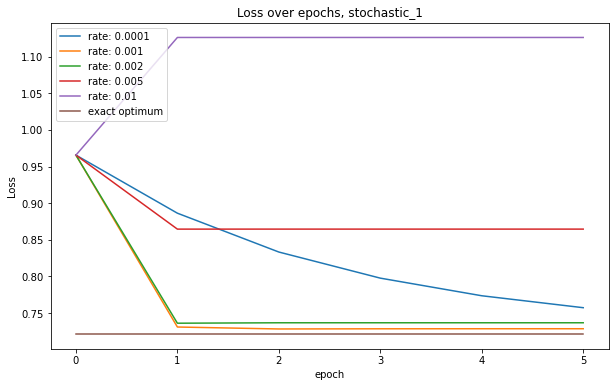

Loss over epochs of stochastic gradient descent with batch size 10


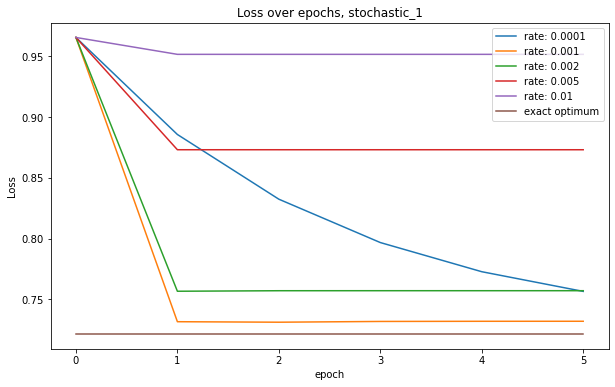

Loss over all iterations of stochastic gradient descent with batch size 1


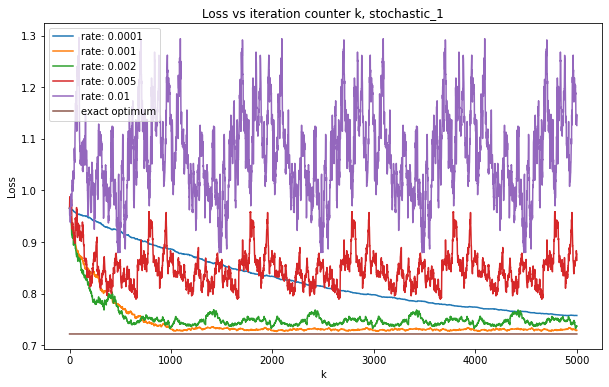

Loss over all iterations of stochastic gradient descent with batch size 10


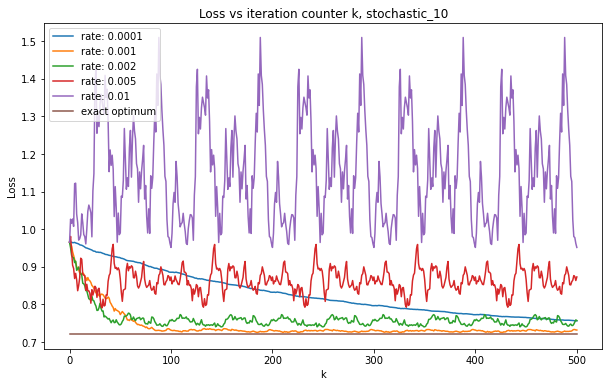

Test RMSE results using the found weights with batch size 1:
Learning rate: 0.0001
	Test RMSE: 0.875065
Learning rate: 0.001
	Test RMSE: 0.87681
Learning rate: 0.002
	Test RMSE: 0.875681
Learning rate: 0.005
	Test RMSE: 0.963746
Learning rate: 0.01
	Test RMSE: 1.015981
Best rate: 0.0001, with min test RMSE: 0.875065
Test RMSE results using the found weights with batch size 10:
Learning rate: 0.0001
	Test RMSE: 0.874877
Learning rate: 0.001
	Test RMSE: 0.878917
Learning rate: 0.002
	Test RMSE: 0.883765
Learning rate: 0.005
	Test RMSE: 0.951683
Learning rate: 0.01
	Test RMSE: 1.029748
Best rate: 0.0001, with min test RMSE: 0.874877


In [14]:
# print results for stochastic gradient descent

# print computation time results
print("Computation time results:")

print("Stochastic Gradient Descent with batch size 1:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    print("\tTook {}s, average {}s per epoch".format(round(SGD_batch_1[rate][4],6), round(SGD_batch_1[rate][4]/num_epochs,6)))

print("Stochastic Gradient Descent with batch size 10:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    print("\tTook {}s, average {}s per epoch".format(round(SGD_batch_10[rate][4],6), round(SGD_batch_10[rate][4]/num_epochs,6)))



ks_epochs = np.arange(num_epochs + 1)

print("Loss over epochs of stochastic gradient descent with batch size 1")
plt.figure(figsize=(10,6))
for rate in learning_rates:
    plt.plot(ks_epochs, SGD_batch_1[rate][3], label="rate: {}".format(rate))
plt.plot(ks_epochs, np.ones(len(ks_epochs))*optimal_loss, label="exact optimum")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs, stochastic_1")
plt.legend(loc='best')
plt.show()

print("Loss over epochs of stochastic gradient descent with batch size 10")
plt.figure(figsize=(10,6))
for rate in learning_rates:
    plt.plot(ks_epochs, SGD_batch_10[rate][3], label="rate: {}".format(rate))
plt.plot(ks_epochs, np.ones(len(ks_epochs))*optimal_loss, label="exact optimum")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs, stochastic_1")
plt.legend(loc='best')
plt.show()


print("Loss over all iterations of stochastic gradient descent with batch size 1")
ks_SGD_batch_1 = np.arange(num_epochs*1000+1)
plt.figure(figsize=(10,6))
for rate in learning_rates:
    plt.plot(ks_SGD_batch_1, SGD_batch_1[rate][1], label="rate: {}".format(rate))
plt.plot(ks_SGD_batch_1, np.ones(len(ks_SGD_batch_1))*optimal_loss, label="exact optimum")
plt.xlabel("k")
plt.ylabel("Loss")
plt.title("Loss vs iteration counter k, stochastic_1")
plt.legend(loc='best')
plt.show()


print("Loss over all iterations of stochastic gradient descent with batch size 10")
ks_SGD_batch_10 = np.arange(num_epochs*100+1)
plt.figure(figsize=(10,6))
for rate in learning_rates:
    plt.plot(ks_SGD_batch_10, SGD_batch_10[rate][1], label="rate: {}".format(rate))
plt.plot(ks_SGD_batch_10, np.ones(len(ks_SGD_batch_10))*optimal_loss, label="exact optimum")
plt.xlabel("k")
plt.ylabel("Loss")
plt.title("Loss vs iteration counter k, stochastic_10")
plt.legend(loc='best')
plt.show()

# find test RMSE using found weights
best_rate = None
best_test_RMSE = float('inf')
print("Test RMSE results using the found weights with batch size 1:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    y_star = predict(x_test, SGD_batch_1[rate][5])
    test_RMSE = compute_RMSE(y_star, y_test)
    print("\tTest RMSE: {}".format(round(test_RMSE,6)))
    
    if test_RMSE < best_test_RMSE:
        best_rate = rate
        best_test_RMSE = test_RMSE

print("Best rate: {}, with min test RMSE: {}".format(best_rate, round(best_test_RMSE,6)))


best_rate = None
best_test_RMSE = float('inf')
print("Test RMSE results using the found weights with batch size 10:")
for rate in learning_rates:
    print("Learning rate: {}".format(rate))
    y_star = predict(x_test, SGD_batch_10[rate][5])
    test_RMSE = compute_RMSE(y_star, y_test)
    print("\tTest RMSE: {}".format(round(test_RMSE,6)))
    
    if test_RMSE < best_test_RMSE:
        best_rate = rate
        best_test_RMSE = test_RMSE

print("Best rate: {}, with min test RMSE: {}".format(best_rate, round(best_test_RMSE,6)))

Computation time results:
Stochastic Gradient Descent with momentum, with batch size 1:
Learning rate: 0.0001, beta: 0.01
	Took 0.460246s, average 0.092049s per epoch
Learning rate: 0.0001, beta: 0.05
	Took 0.430507s, average 0.086101s per epoch
Learning rate: 0.0001, beta: 0.1
	Took 0.437744s, average 0.087549s per epoch
Learning rate: 0.0001, beta: 0.5
	Took 0.376701s, average 0.07534s per epoch
Learning rate: 0.0001, beta: 0.7
	Took 0.415986s, average 0.083197s per epoch
Learning rate: 0.0001, beta: 0.9
	Took 0.343911s, average 0.068782s per epoch
Learning rate: 0.001, beta: 0.01
	Took 0.366608s, average 0.073322s per epoch
Learning rate: 0.001, beta: 0.05
	Took 0.396762s, average 0.079352s per epoch
Learning rate: 0.001, beta: 0.1
	Took 0.359224s, average 0.071845s per epoch
Learning rate: 0.001, beta: 0.5
	Took 0.355111s, average 0.071022s per epoch
Learning rate: 0.001, beta: 0.7
	Took 0.363493s, average 0.072699s per epoch
Learning rate: 0.001, beta: 0.9
	Took 0.362115s, average

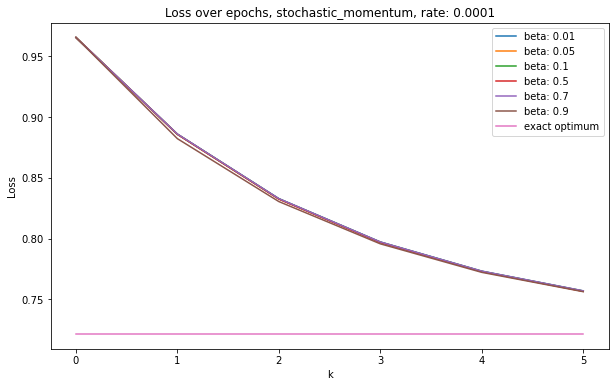

Learning rate: 0.001


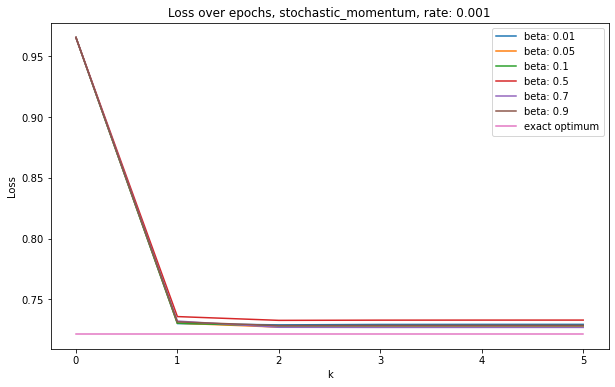

Learning rate: 0.002


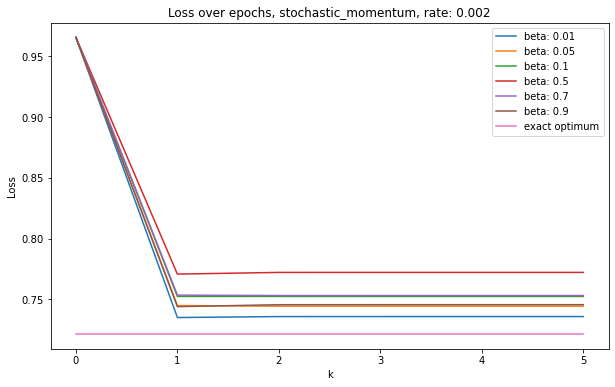

Learning rate: 0.005


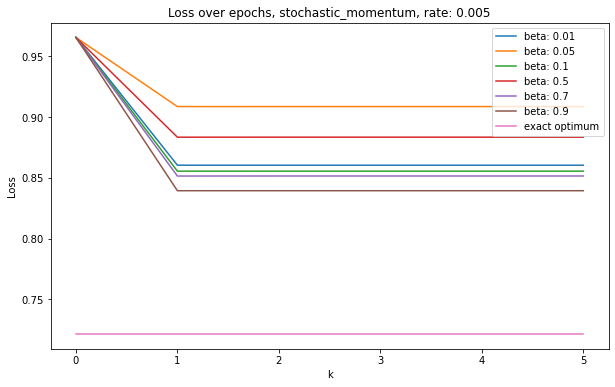

Learning rate: 0.01


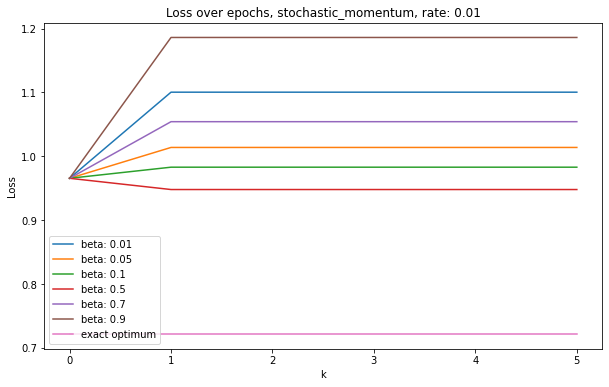

Learning rate: 0.0001


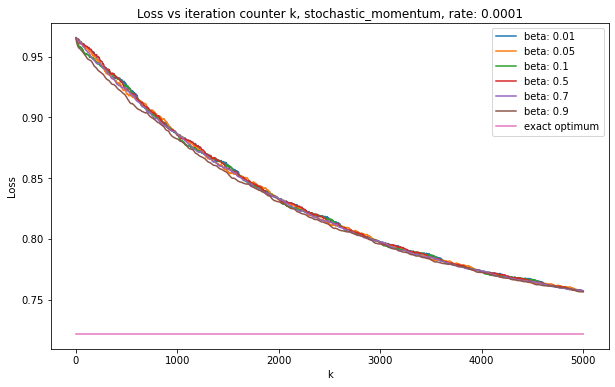

Learning rate: 0.001


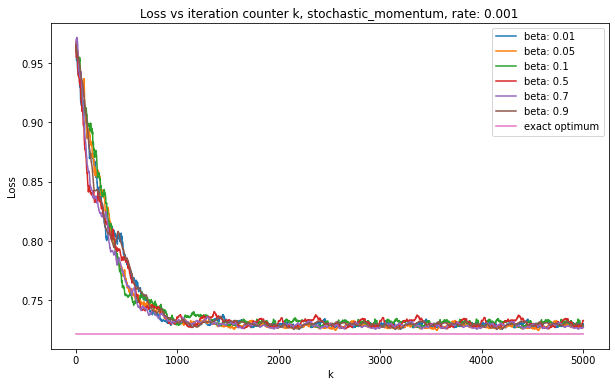

Learning rate: 0.002


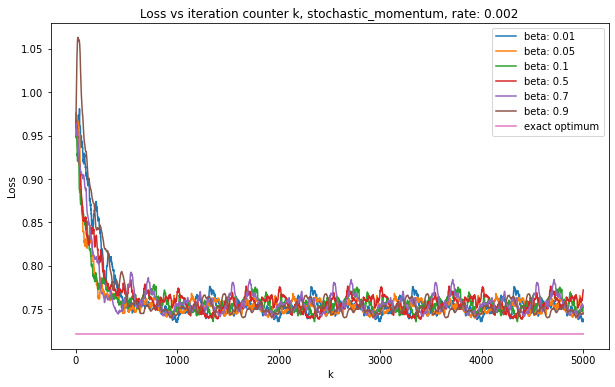

Learning rate: 0.005


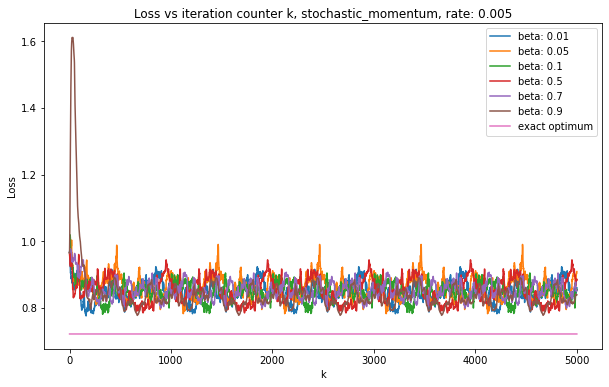

Learning rate: 0.01


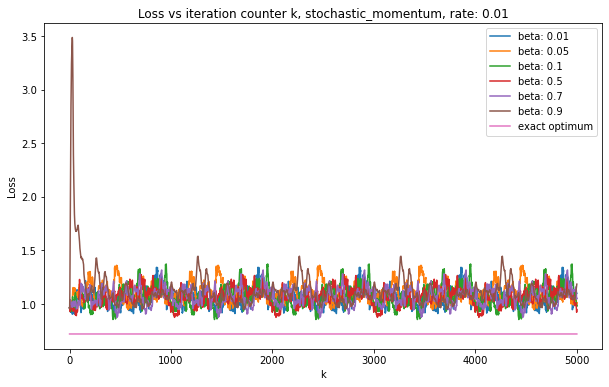

Test RMSE results using the found weights with momentum, with batch size 1:
Learning rate: 0.0001, beta: 0.01
	Test RMSE: 0.874739
Learning rate: 0.0001, beta: 0.05
	Test RMSE: 0.874923
Learning rate: 0.0001, beta: 0.1
	Test RMSE: 0.874486
Learning rate: 0.0001, beta: 0.5
	Test RMSE: 0.87475
Learning rate: 0.0001, beta: 0.7
	Test RMSE: 0.874659
Learning rate: 0.0001, beta: 0.9
	Test RMSE: 0.874919
Learning rate: 0.001, beta: 0.01
	Test RMSE: 0.872978
Learning rate: 0.001, beta: 0.05
	Test RMSE: 0.872441
Learning rate: 0.001, beta: 0.1
	Test RMSE: 0.875806
Learning rate: 0.001, beta: 0.5
	Test RMSE: 0.876788
Learning rate: 0.001, beta: 0.7
	Test RMSE: 0.871796
Learning rate: 0.001, beta: 0.9
	Test RMSE: 0.875848
Learning rate: 0.002, beta: 0.01
	Test RMSE: 0.88014
Learning rate: 0.002, beta: 0.05
	Test RMSE: 0.881051
Learning rate: 0.002, beta: 0.1
	Test RMSE: 0.88023
Learning rate: 0.002, beta: 0.5
	Test RMSE: 0.891285
Learning rate: 0.002, beta: 0.7
	Test RMSE: 0.880505
Learning rate:

In [15]:
# print results for stochastic gradient descent with momentum

# print computation time results
print("Computation time results:")

print("Stochastic Gradient Descent with momentum, with batch size 1:")
for rate in learning_rates:
    for beta in betas:
        print("Learning rate: {}, beta: {}".format(rate, beta))
        print("\tTook {}s, average {}s per epoch".format(round(SGD_momentum[rate][beta][4],6), round(SGD_momentum[rate][beta][4]/num_epochs,6)))


ks_epochs = np.arange(num_epochs + 1)

for rate in learning_rates:
    
    print("Learning rate: {}".format(rate))
    plt.figure(figsize=(10,6))
    for beta in betas:
        plt.plot(ks_epochs, SGD_momentum[rate][beta][3], label="beta: {}".format(beta))
    plt.plot(ks_epochs, np.ones(len(ks_epochs))*optimal_loss, label="exact optimum")
    plt.xlabel("k")
    plt.ylabel("Loss")
    plt.title("Loss over epochs, stochastic_momentum, rate: {}".format(rate))
    plt.legend(loc='best')
    plt.show()

ks_SGD_batch_1 = np.arange(num_epochs*1000+1)
for rate in learning_rates:
    
    print("Learning rate: {}".format(rate))
    plt.figure(figsize=(10,6))
    
    for beta in betas:
        plt.plot(ks_SGD_batch_1, SGD_momentum[rate][beta][1], label="beta: {}".format(beta))
    plt.plot(ks_SGD_batch_1, np.ones(len(ks_SGD_batch_1))*optimal_loss, label="exact optimum")
    plt.xlabel("k")
    plt.ylabel("Loss")
    plt.title("Loss vs iteration counter k, stochastic_momentum, rate: {}".format(rate))
    plt.legend(loc='best')
    plt.show()

# find test RMSE using found weights
print("Test RMSE results using the found weights with momentum, with batch size 1:")

best_rate = None
best_beta = None
best_test_RMSE = float('inf')

for rate in learning_rates:
    for beta in betas:
        print("Learning rate: {}, beta: {}".format(rate, beta))
        y_star = predict(x_test, SGD_momentum[rate][beta][5])
        test_RMSE = compute_RMSE(y_star, y_test)
        print("\tTest RMSE: {}".format(round(test_RMSE,6)))
        
        if test_RMSE < best_test_RMSE:
            best_rate = rate
            best_beta = beta
            best_test_RMSE = test_RMSE
            
print("Best rate: {}, best beta: {}, with min test RMSE: {}".format(best_rate, best_beta, round(best_test_RMSE,6)))